# Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge
value.
The goal here is to evaluate whether a pricing test running on the site has been successful.
As always, you should focus on user segmentation and provide insights about segments
who behave differently as well as any other insights you might find.

## Problem description

Company XYZ sells a software for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66\% of the users have seen the old price (39), while a random sample of 33\% users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

- __Should the company sell its software for 39 or 59__?
- The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. __What are your main findings looking at the data__?
- The VP of Product feels that the test has been running for too long and he should
have been able to get statistically significant results in a shorter time. Do you agree with
her intuition? After how many days you would have stopped the test? Please, explain why.


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from scipy.stats import ttest_ind
from sklearn.feature_selection import chi2,f_classif
import warnings
warnings.filterwarnings('ignore')

In [3]:
user = pd.read_csv('user_table.csv')

In [4]:
user

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68
...,...,...,...,...,...
275611,485975,Atlanta,USA,33.76,-84.42
275612,35479,Los Angeles,USA,34.11,-118.41
275613,516519,Chicago,USA,41.84,-87.68
275614,984877,Tampa,USA,27.96,-82.48


In [5]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [6]:
data = pd.read_csv('test_results.csv')

In [7]:
data.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [9]:
#Discover and visualize the data to gain insights
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

Variable     count of unique value    content
user_id              316800	 [3, 9, 14, 16, 19]
timestamp            140931	 ['2015-03-02 00:04:12', '2015-03-02 00:12:40', '2015-03-02 00:16:25', '2015-03-02 00:18:46', '2015-03-02 00:22:21']
source                  12	 ['ads-bing', 'ads-google', 'ads-yahoo', 'ads_facebook', 'ads_other']
device                   2	 ['mobile', 'web']
operative_system         6	 ['android', 'iOS', 'linux', 'mac', 'other']
test                     2	 [0, 1]
price                    2	 [39, 59]
converted                2	 [0, 1]


In [10]:
result = pd.merge(left = data, right = user, how = 'left', on = ['user_id', 'user_id'])

In [11]:
result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [12]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316800 non-null  int64  
 1   timestamp         316800 non-null  object 
 2   source            316800 non-null  object 
 3   device            316800 non-null  object 
 4   operative_system  316800 non-null  object 
 5   test              316800 non-null  int64  
 6   price             316800 non-null  int64  
 7   converted         316800 non-null  int64  
 8   city              275616 non-null  object 
 9   country           275616 non-null  object 
 10  lat               275616 non-null  float64
 11  long              275616 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 31.4+ MB


In [13]:
# Problem with the data: test and price not match
result[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

The test data is not totally match the with the lable so we need to modify the data

In [18]:
result = result[((result['test'] == 0) & (result['price'] == 39)) | ((result['test'] == 1) & (result['price'] == 59))]

In [46]:
result['revenue'] = result['price'] * result['converted']

In [24]:
result.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,59
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [26]:
result.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

converation of original price 39

In [22]:
conversion_0 = result['price'][result['price'] == 39][result['converted'] == 1].count() / result['price'][result['price'] == 39].count()
print('convertion rate', "%.5f" % conversion_0, '%')

convertion rate 0.01990 %


converation of original price 59

In [23]:
conversion_1 = (result['price'][result['price'] == 59][result['converted'] == 1].count()) / result['price'][result['price'] == 59].count()
print('new convertion rate', "%.5f" % conversion_1, '%')

new convertion rate 0.01556 %


In [43]:
result[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [49]:
result[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


New price lead to a bit decrease in conversion rate but average revenue increases.

In [52]:
ctr_val = result[result['test'] == 0]['revenue'].values
exp_val = result[result['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


since the p-value is much smaller than 0.05 threshold, so we reject H0, and accept HA, that is, test group's average revenue is significantly higher than control group's average revenue.

but due to OS distribution aren't the same between test/control groups, price isn't the only difference between test/control groups, so we cannot contribute the increase in average revenue to price.

the experiment design fails, I cannot answer decide whether we can sell software to all users in 59 dollars. I suggest

- find the reason why IOS users have different representation ratio than other devices.
- then run the experiment again, make sure price is the only difference between test and control group
- then run t-test again, to see whether the average revenue is significantly improved.

Although our test suggest that $\$59$ price can give us higher average revenue. However, due to the problem with the A/B test, the above result is not scientifically accurate. More scientific A/B test is needed.

## Discover and visualize the data to gain insights

- source
- device	
- operative_system

In [36]:
# Visulazation of source
data = result.groupby('converted')['source'].apply(lambda s: s.value_counts(normalize = True)).unstack()
data 

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
converted,,,,,,,,,,,,
0,0.072616,0.186928,0.024012,0.168121,0.094639,0.191644,0.063992,0.006738,0.073254,0.029292,0.021665,0.067098
1,0.047225,0.219924,0.019304,0.194933,0.073768,0.127715,0.137883,0.008790,0.067735,0.024991,0.019131,0.058600


<AxesSubplot:xlabel='converted'>

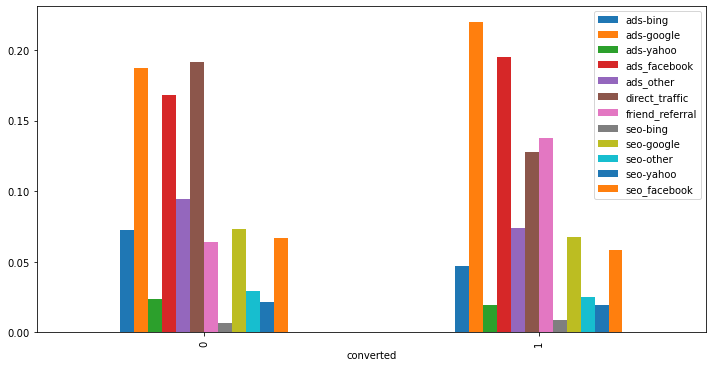

In [38]:
data.plot(kind='bar', figsize = (12, 6))

In [39]:
# Visulazation of device
data = result.groupby('converted')['device'].apply(lambda s: s.value_counts(normalize = True)).unstack()
data

,mobile,web
converted,,
0,0.588511,0.411489
1,0.595657,0.404343


<AxesSubplot:xlabel='converted'>

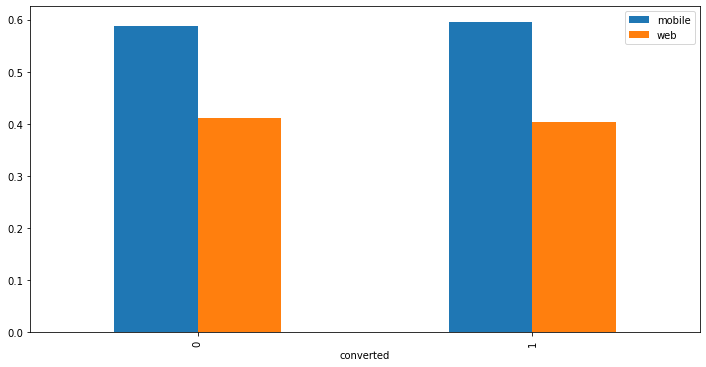

In [40]:
data.plot(kind='bar', figsize = (12, 6))

In [41]:
# Visulazation of operative_system
data = result.groupby('converted')['operative_system'].apply(lambda s: s.value_counts(normalize = True)).unstack()
data

,android,iOS,linux,mac,other,windows
converted,,,,,,
0,0.237428,0.300110,0.013186,0.078723,0.051401,0.319152
1,0.192520,0.366942,0.005860,0.103585,0.036194,0.294898


<AxesSubplot:xlabel='converted'>

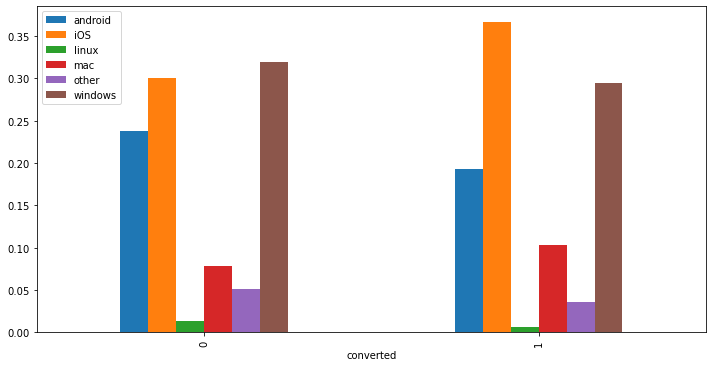

In [42]:
data.plot(kind='bar', figsize = (12, 6))

The conversion rate of android user decreases 4.5% and increases 6.6% in IOS user 

## Question 2

In [53]:
result.groupby('source')['converted'].mean()

source
ads-bing           0.012001
ads-google         0.021502
ads-yahoo          0.014793
ads_facebook       0.021198
ads_other          0.014350
direct_traffic     0.012294
friend_referral    0.038688
seo-bing           0.023787
seo-google         0.016978
seo-other          0.015686
seo-yahoo          0.016226
seo_facebook       0.016051
Name: converted, dtype: float64

Chi-Square test
run Chi-Square test to see which feature greatly impact converted or not

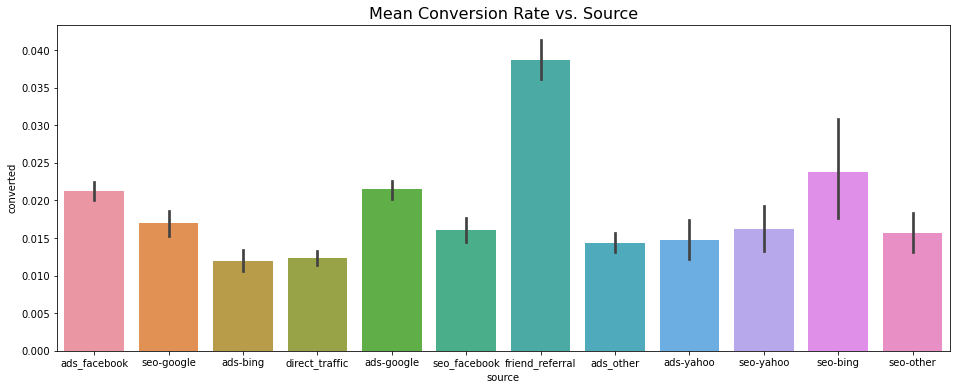

In [57]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=result, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

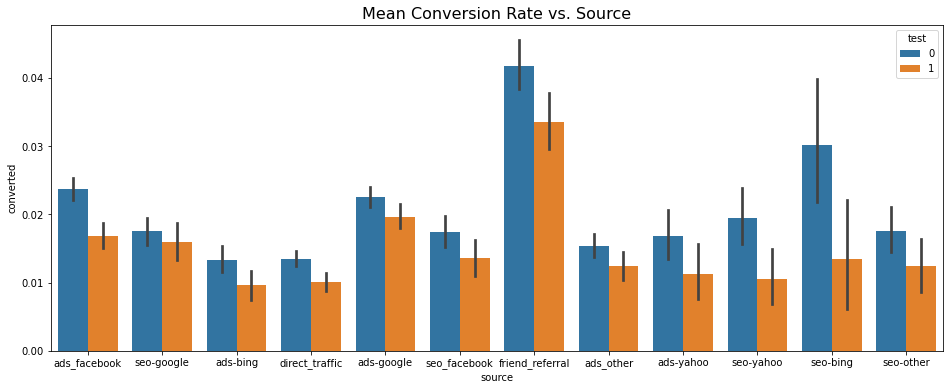

In [55]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=result, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

In [69]:
result.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


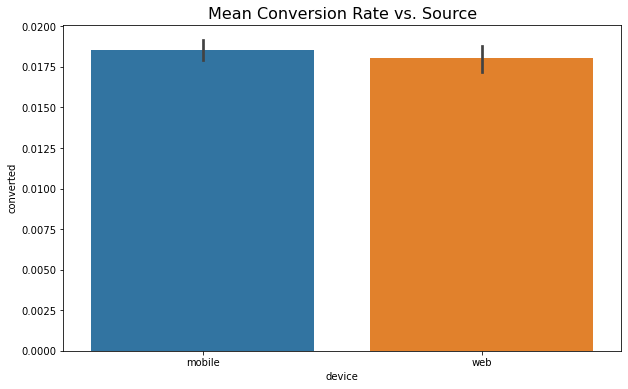

In [65]:
# Visualization of source
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='device', y='converted', data=result, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

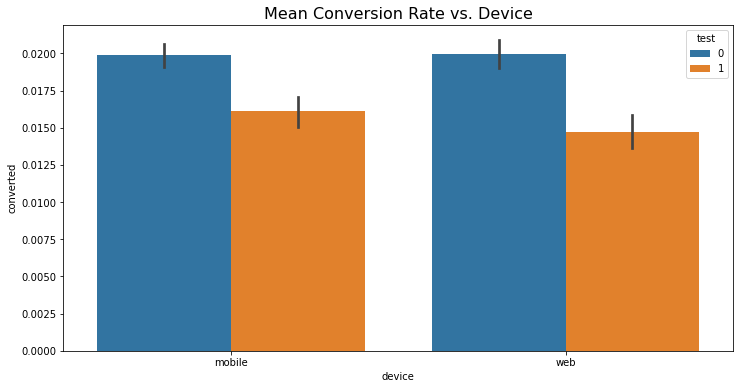

In [66]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', hue='test', data=result, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

In [67]:
result.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


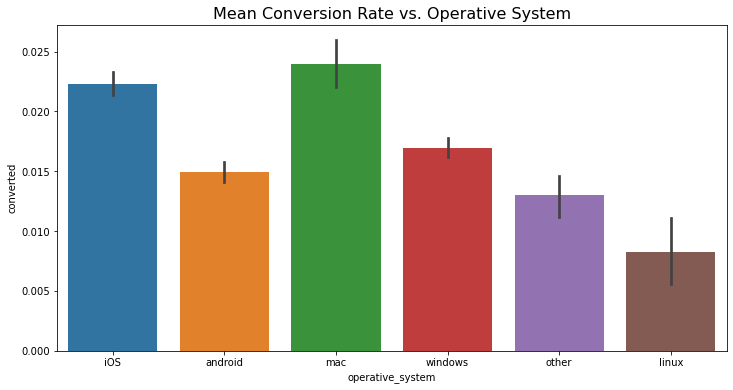

In [70]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=result, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

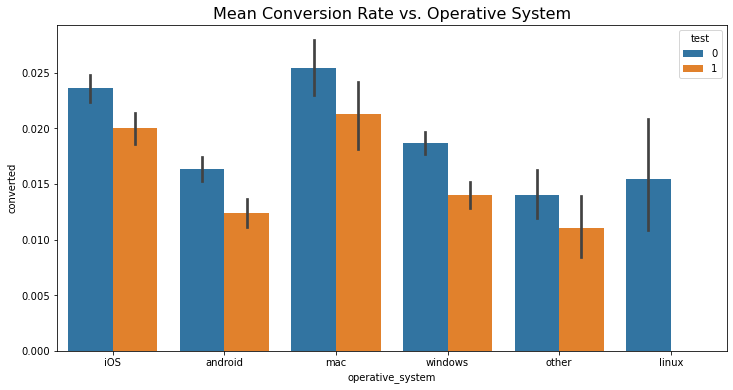

In [71]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=result, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

From above visualizations, we can easily conclude that price dramatically influence the conversion rate. But beside price, there are still other factors that can influence the conversion rate.

- Source
Friend-referral users have much higher conversion rate
- Device
The influence of device is not significant
- Operative System
Mac and ios users have much higher conversion rate


#### Actionable Insights (refer to online resource)
friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors

lauch special marketing program targeted to Apple users (MAC or iOS users)
run some program which rewards user which can invite his/her friend to use our software
Linux users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?